**Problem Statement** <br>

Company X intends to build a face identification model to recognise human faces

**Data Set** <br>
The dataset comprises of images and its mask where there is a human face.

**Objective** <br>

Face  Aligned  Face  Dataset  from  Pinterest.  This  dataset  contains  10,770  images  for  100  people.  All  images  are  taken from 'Pinterest' and aligned using dlib library. 

Importing Tensor Flow

In [2]:
import matplotlib.pyplot as plt
import tensorflow
tensorflow.__version__

'2.4.1'

Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Locading the Images and meta data

In [4]:
train_images = '/content/drive/MyDrive/Part 3 - Aligned Face Dataset from Pinterest(2).zip'

In [5]:
import zipfile
archive = zipfile.ZipFile(train_images, 'r')
archive.extractall()

In [8]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [9]:
metadata # verifying the data

array([PINS/pins_brie larson/brie larson1.jpg,
       PINS/pins_brie larson/brie larson54.jpg,
       PINS/pins_brie larson/brie larson123.jpg, ...,
       PINS/pins_miguel herran/miguel herran23_296.jpg,
       PINS/pins_miguel herran/miguel herran159_367.jpg,
       PINS/pins_miguel herran/miguel herran77_297.jpg], dtype=object)

In [10]:
import cv2 # impoting opencv2

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

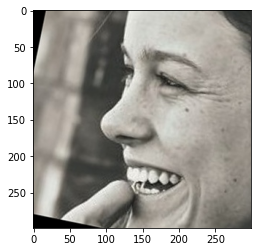

In [11]:
img_1 = load_image(metadata[44].image_path())
plt.imshow(img_1)

Building the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1),  input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Locading vgg face weight

In [13]:
model = vgg_face()
model.load_weights('/content/drive/MyDrive/Part 3 - vgg_face_weights(1).h5')

Get Embedding vetors for Images

In [14]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs = model.layers[-2].output)

In [15]:

# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)



(224, 224, 3)
(2622,)


In [16]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i in range(len(metadata)):
    img_path = metadata[i].image_path()
    print(i, metadata[i])
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224, 224))
    
    #obtaining embedding vectors of all images
    embedding_vectors = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
    embeddings[i] = embedding_vectors

Streaming output truncated to the last 5000 lines.
5770 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies114.jpg
5771 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies53.jpg
5772 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies115.jpg
5773 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies6.jpg
5774 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies38.jpg
5775 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies70.jpg
5776 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies95.jpg
5777 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies41.jpg
5778 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies89.jpg
5779 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies30.jpg
5780 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies83.jpg
5781 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies64.jpg
5782 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies58.jpg
5783 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies68.jpg
5784 PINS/pins_Sarah Wayne Callies/Sarah Wayne Callies33.jpg
5785 PINS/pins_Sarah Wayne Callie

Define the distance vector 

In [17]:
def distance(emb1, emb2): # using the euclidean distance formuka 
    return np.sum(np.square(emb1 - emb2))

Checking Distances for various images

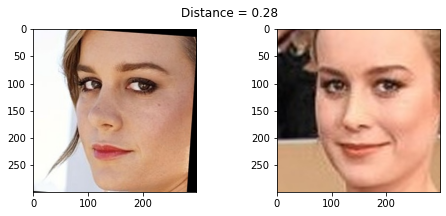

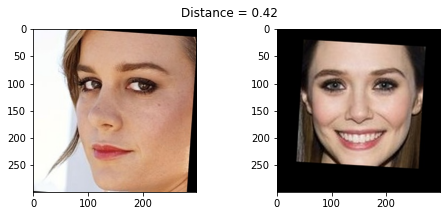

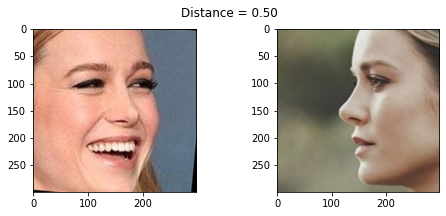

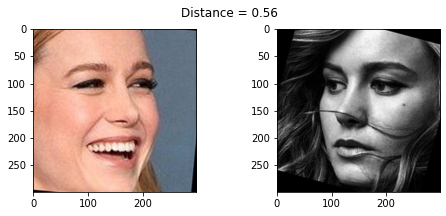

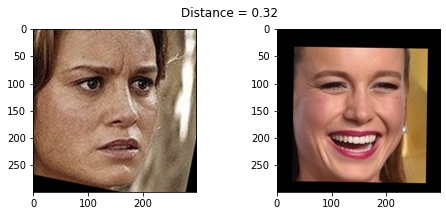

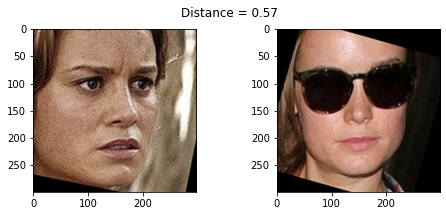

In [21]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(8, 3)
show_pair(8, 180)

show_pair(45, 102)
show_pair(45, 48)

show_pair(99, 72)
show_pair(99, 115)

Train Test Split

In [22]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

In [23]:
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

In [24]:
from sklearn.preprocessing import LabelEncoder

target = np.array([m.name for m in metadata])
enc = LabelEncoder()
enc.fit(target)

y = enc.transform(target)
y_train = y[train_idx]
y_test = y[test_idx]

Scaling the data

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Principle Component Analysis

In [27]:
from sklearn.decomposition import PCA

pca = PCA() 
  
X_train = pca.fit_transform(X_train_scaled) 
X_test = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[1.35365936e-01 5.41603499e-02 3.96353868e-02 ... 1.67668086e-09
 1.62021966e-09 9.31808939e-11]


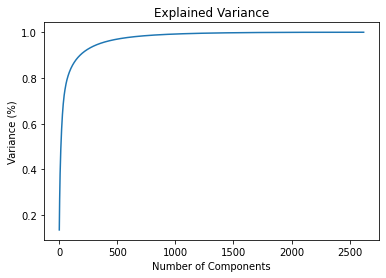

In [28]:
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

In [31]:
pca = PCA(n_components = 1200) 
  
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[1.36017352e-01 5.44209838e-02 3.98261227e-02 ... 1.07204874e-05
 1.06627913e-05 1.05525917e-05]


Model Development & Training

In [32]:
from sklearn.svm import SVC

svc = SVC(C = 1.0, kernel = 'rbf', gamma = 'scale')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score

print('Accuracy Score of SVC Model- ', accuracy_score(y_test, svc_pred))

Accuracy Score of SVC Model-  0.9582289055973267


In [39]:
X_test[21].shape

(1200,)

In [46]:
example_image = example_image.flatten()

In [47]:
example_image.shape

(150909,)

Prediction & Analysis

Text(0.5, 1.0, 'Identified as pins_elizabeth olsen face')

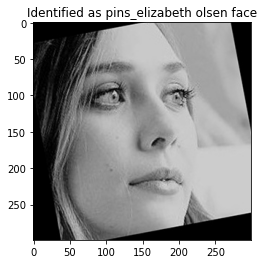

In [34]:
example_idx = 21

example_image = load_image(metadata[test_idx][example_idx].image_path())

#transforming the embedding of the 21st image
example_prediction = svc.predict([X_test[example_idx]])

#inverse transformation of the 21st image
example_identity = enc.inverse_transform(example_prediction)[0]

plt.imshow(example_image)

#the image belongs to which person
plt.title(f'Identified as {example_identity}')

**Conclusion & Analysis**

*   The data was loaded and processed for building face recognition model
*   Function for calculating the distance between the models was defined
*   PCA was done to identify the most important features
*   A SVC Model as built to predict a random image




